# Evaluation of Kalman filtering for linear and logistic regression
# Part I: generation of synthetic datasets

In [11]:
import sys
sys.path.insert(1, './LargeScaleKalmanLibrary/')
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Introduction

In this tutorial we show how to use the Kalman filter for large scale regression and binary classification problems. 

In this part, we generate synthetic datasets of training datas for linear regression and logistic regression. 

# Data generation for linear regression

We want to generate $t$ random training datas $(u_1,y_1);...;(u_t,y_t)$ where $u_i$ is an input vector and $y_i$ a scalar output. This training datas must be generated in a way that the associated cost function is constrained to be a least mean square loss or a logistic loss.

Each terms $i$ of the least mean square loss takes the form:

\begin{align}
l_i(x)&=\frac{1}{2}(y_i - H_ix)^T R_i^{-1} (y_i - H_ix)\\
&=\frac{1}{2}x^TH_i^TR_i^{-1}H_ix -  y_i R_i^{-1} H_ix +  \frac{1}{2}y_i^T R_i^{-1} y_i.
\end{align}

We suppose we are in the simplified case where the outputs are scalars ($H_i=u_i^T$) and the weighting matrix $R_i$ is supposed the same for all obervations ($R_i=\sigma^2$). Choosing $R_i$ which do not depends on $i$ correspond to take an homoscedastic noise for $y$. The one sample loss in this case can be rewritten:

\begin{align}
l_i(x)&=\frac{1}{2}\frac{(y_i - u_i^Tx)^2}{\sigma^{2}}\\
&=\frac{1}{2} x^T \frac{u_iu_i^T}{\sigma^{2}}x -  \frac{y_iu_i^T}{\sigma^{2}}x +  \frac{1}{2}\frac{y_i^2}{\sigma^{2}},\\
&
\end{align} 


and the least mean square cost function for $N$ observations can be written:

\begin{align}
L^{tot}_N(x)&=\frac{1}{N}\sum_{i=1}^N l_i(x)\\
&= \frac{1}{2} x^T (\frac{1}{N} \sum_{i=1}^N  \frac{u_iu_i^T}{\sigma^{2}})x -  (\frac{1}{N}\sum_{i=1}^N \frac{y_iu_i^T}{\sigma^{2}})x +  \frac{1}{2N}\sum_{i=1}^N  \frac{y_i^2}{\sigma^{2}}\\
&=  \frac{1}{2} x^TQx - v^Tx + C \hspace{1cm} \text{    where C is a term independent of x}.\\
&
\end{align}

To generate synthetic data we will suppose $u$ and $y$ are Gaussian variables and we search the Gaussian parameters such that we form a least mean square problem. For $y$, we have directy from the factorized form of least mean square that:

\begin{align}
&y_i \sim \mathcal{N}(u_i^Tx^{*},\sigma^2) \propto \exp(-l_i(x^*)),\\
&
\end{align}

where $x^*$ is the minimizer of the least mean square problem. Remark that if  $x^*$ is a nul vector, the outputs do not depends on the inputs and the estimation problem is degenerated. Now we can define the Gaussian parameters for $u$ by remarking that the Hessian of the least mean square loss $Q$ is related to the covariance of $u$:

\begin{align}
Q &\sim \frac{\mathbb{E}[uu^T]}{\sigma^2},\\
&
\end{align}

and finally the linear term $v_t$ can be re-written in function of $u$: 

\begin{align}
v^T &\sim \frac{\mathbb{E}[yu^T]}{\sigma^2}\\
&\sim \frac{\mathbb{E}[(u^Tx^{*}+\varepsilon)u^T]}{\sigma^2} \text{ with $\varepsilon \sim \mathcal{N}(0,\sigma^2)$}\\
&\sim \frac{{x^{*}}^T\mathbb{E}[uu^T]+\mathbb{E}[\varepsilon u^T]}{\sigma^2}\\
&\sim {x^{*}}^TQ,\\
&
\end{align}

where $\mathbb{E}[\varepsilon u^T]=0$ because $\varepsilon$ do not depends on $u$ (homoscedastic noise). The mean of $u$ have no incidence on the least mean square form and we will consider zero mean inputs such that $Q \sim \frac{\mathrm{Cov}(u)}{\sigma^2}$. Moreover since the noise is scalar, the weigthed least square problem is equivalent to the non weighted form up to a scaling factor. We then drop the sigma term from the Hessian to prevent too large scaling when we put high noise: $Q \sim \mathrm{Cov}(u)$. For our experiments we want to force the condition number of the Hessian matrix to be low to assess improvement offer by second order method. We can manage this condition number by tuning properly the covariance of $u$:

\begin{align}
\mathrm{Cov}(u)= P_u =
M^T\sigma_u^2 \begin{pmatrix} 
1 &0 &.. &0 \\
0 & \frac{1}{2^c}&.. & 0 \\
. &. &.. &. \\
. & .&.. &. \\
0 &0 & .. &\frac{1}{d^c}\\
\end{pmatrix} M \\
&
\end{align}

where $\sigma_u$ is the standard deviation of the largest coordinates of inputs (if inputs not normalized), $d$ is the dimension of the state $x$, $c$ is a constant and $M$ is a random rotation matrix generated from the uniform distribution on $SO(d)$. 

Finally, the synthetic scheme is the following:

1. generate N inputs vector $u_i$ such that $u_i \sim \mathcal{N}(0,P_u)$.
2. generate the optimal $x^*$ as a random gradient vector of desired norm, the gradient is then defined as $v \sim Qx^*$.
4. generate N outputs values such that $y_i \sim \mathcal{N}(u_i^Tx^{*},\sigma^2)$.

We introduce additional options: the user can choose different settings for the covariance matrix $\mathrm{Cov}(u)$ : isotropic (ie identity) or without rotation (ie aligned on canonical axis) or composed of spikes (ie several eigen values to $1$, others to very low values):

\begin{align}
&\text{Spikes case with $c$ spikes:} \\
&\mathrm{Cov}(u)= 
M^T\sigma_u^2 \begin{pmatrix} 
\frac{1}{d} &0 &.. &0 \\
0 & 1 &.. & 0 \\
. & .&.. &. \\
. & .& \frac{1}{d} &. \\
0 &0 & .. &1\\
\end{pmatrix} M \\
&
\end{align}

In [2]:
import numpy as np 
from scipy.stats import special_ortho_group
import numpy.linalg as LA
import math
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [3]:
# helper function to compute sparse vectors
def compteSparseVector(d,values,multiplicities):
    a=np.ones(d)*1
    idxValues=np.random.permutation(np.arange(0,d))
    idx_a=0
    for i in range(0,len(values)):
        p=int(multiplicities[i])
        a[idxValues[idx_a:idx_a+p]]=values[i]
        idx_a=idx_a+p
    return a

In [4]:
def LMS_data_generator(N,d,c,sigmaOutput,scaleInput,seed=np.random.randint(0,100000),covarianceInputs='ill-conditionned'\
                       ,normOptimal=1):
    """
    Generate training datas for the least mean square loss Sum_i (yi-ui^Tx)/sigma^2

    Parameters
    ----------
    N : int
        the number of training datas. 
    d : int
        the dimension of the hidden state (= dimension of input for a linear regressor).
    c : float
        a constant which drive the condition number of H : mu=(1/d)^c if covarianceInputs=ill-conditionned 
        or the number of spikes if covarianceInputs=spikes.
    sigmaOutput : float 
        the standard deviation of the outputs (supposed scalars). 
    scaleInput : float 
        a scaling factor for the distribution of inputs.
    seed : float
        the seed used to reproduce results
    covarianceInputs : string : 
        allowed values are: 'isotropic','aligned-ill-conditionned','ill-conditionned','spikes'
    Returns
    -------
    Y : vector Nx1 
        the vector of outputs.
    U : matrix Nxd
        the training inputs organized as rows of a matrix.
    x_opt : float
        the true optimal.
   Cov_u : float
        the covariance matrix used to generate inputs.
    """
    
    # computation of the Covariance of inputs 
    if covarianceInputs=='ill-conditionned' or covarianceInputs=='aligned-ill-conditionned':
        Cov_u=np.diag(1/np.arange(1,d+1)**c)*scaleInput**2
    if d>1 and covarianceInputs=='ill-conditionned':
        np.random.seed(seed)
        Q = special_ortho_group.rvs(dim=d)
        Cov_u=np.transpose(Q).dot(Cov_u).dot(Q)
    if covarianceInputs=='isotropic':
        Cov_u=np.identity(d)*sigmaInput**2
    if covarianceInputs=='spikes':
        if c>d:
            raise Exception('error: c must be < d for spikes')
        values=np.hstack((1,np.random.uniform(1/d,0.5,d-c)))
        multiplicities=np.hstack((c,np.ones(d-c)))
        Cov_u=np.diag(compteSparseVector(d,values,multiplicities))*sigmaInput**2
        if d>1:
            np.random.seed(seed)
            Q = special_ortho_group.rvs(dim=d)
            Cov_u=np.transpose(Q).dot(Cov_u).dot(Q)
    
    # generate a random optimal
    np.random.seed(seed)
    x_opt=np.random.uniform(-1,1,d)
    x_opt=x_opt*normOptimal/LA.norm(x_opt) 
    
    # generate the inputs
    mean_u = np.zeros((d,))
    np.random.seed(seed)
    U=np.random.multivariate_normal(mean_u,Cov_u,(N))
        
    # generate the outputs
    Y=U.dot(x_opt)
    if sigmaOutput>0:
        np.random.seed(seed)
        Y=Y+np.random.normal(0,sigmaOutput,N).reshape(N,)
        
    return Y.reshape(N,1),U,x_opt,Cov_u

In [5]:
def LMSLoss(Y,U,x):
    N,d=U.shape
    H=0.5*U.T.dot(U)/N
    Y=Y.reshape(N,1)
    v=np.mean(Y*U,axis=0)
    c=0.5*np.mean(Y**2)
    return x.T.dot(H).dot(x)-v.T.dot(x)+c

Let us experiment it on a simple case:

In [6]:
N=1000
d=2
c=3
sigmaLabel=-1
sigmaInput=1
Y,U,x_opt,Cov_u=LMS_data_generator(N,d,c,sigmaLabel,sigmaInput,covarianceInputs='ill-conditionned',seed=3)
print('the loss with x=x_opt is',LMSLoss(Y,U,x_opt))
print(Cov_u)

the loss with x=x_opt is 3.885780586188048e-16
[[0.95081522 0.20153793]
 [0.20153793 0.17418478]]


We can check we obtain the desired Gaussians for $y$ and $u$:

the optimal is:
 [0.23708896 0.97148794]
Approximated Hessian matrix=
 [[1.    0.   ]
 [0.    0.125]]
Empirical Hessian matrix=
 [[0.99296699 0.        ]
 [0.         0.13165565]]


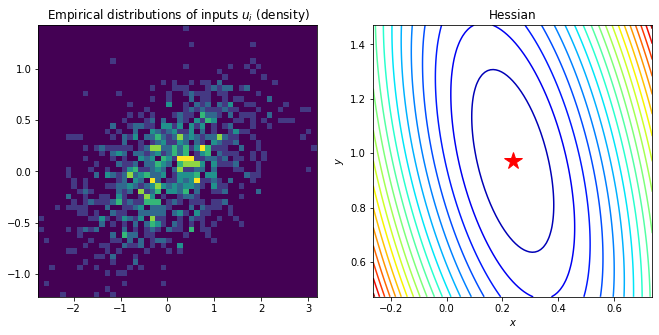

In [12]:
from LargeScaleKalmanLibrary.Evaluation import plotLMSShape

fig,(ax1,ax2)=plt.subplots(1,2,num=2,figsize=(11,5))
print('the optimal is:\n',x_opt)
print('Approximated Hessian matrix=\n',np.diag(LA.linalg.eig(Cov_u)[0]))
print('Empirical Hessian matrix=\n',np.diag(LA.linalg.eig(U.T.dot(U)/N)[0]))
ax1.hist2d(U[:,0],U[:,1],50)
ax1.set_title('Empirical distributions of inputs $u_i$ (density)')
plotLMSShape(ax2,x_opt,U.T.dot(U)/N,nbcontours=20)
ax2.set_title('Hessian')
plt.show()

Let us plot now the outputs associated to each inputs with a colormap. When the standard deviation $\sigma$ of noise is low, we see clearly the linear model which appear: the outputs are aligned along the direction $x^*$. 

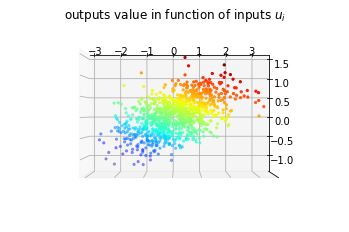

In [13]:
from mpl_toolkits.mplot3d import Axes3D 
fig=plt.figure(5)
ax=fig.add_subplot(111,projection='3d')
ax.view_init(90, -90)
ax.set_zticks([])
ax.scatter(U[:,0],U[:,1],Y,c=Y.reshape(N,),cmap='jet',marker='.',s=20)
plt.title('outputs value in function of inputs $u_i$')
plt.show()

Finally we can plot the distribution of means of outputs $\mu_i=\mathbf{E}[y_i]=u_i^Tx^*$. This 1D distribution is Gaussian since it is a linear combination of the Gaussian distribution of inputs $u_i$.  

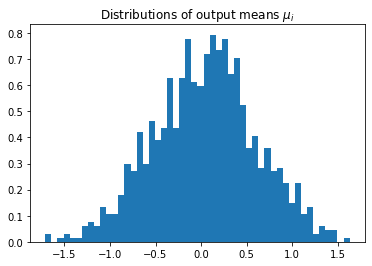

In [14]:
plt.figure(3)
plt.hist(U.dot(x_opt),50, density=True)
plt.title('Distributions of output means $\mu_i$')
plt.show()

# Data generation for logistic regression

## First approach with 1 Gaussian

Now suppose we have binary outputs $y=\{0,1\}$ following a Bernouilli distribution of mean $\mu$ which depends on a parameter $\eta$ through the sigmoïd response function $\sigma$ :
\begin{align}
&  p(y/\mu) = \mu^y(1-\mu)^{1-y} \\
& \text{ with } \mu=\sigma(\eta)=\frac{1}{1+e^{-\eta}}.\\%=\frac{1}{1+e^{-(u^Tx^*+\varepsilon})}.\\
&
\end{align}  
The sigmoïd function have the following properties:
1. complementarity: $\sigma(-\eta)=1-\sigma(\eta)$
2. inverse: $\eta=\log(\frac{\mu}{1-\mu})$
3. derivation: $\sigma^\prime(\eta)=\sigma(\eta)(1-\sigma(\eta))$
4. primitive: $\int_{-\infty}^\eta\sigma(\eta)d\eta=\log(1+e^\eta)$

Let us consider now the $i^{th}$ observation $y_i$ of parameters $\eta_i$. We suppose $y_i$ is related to an input $u_i$ throught the linear relation $\eta_i=u_i^Tx^*$, where $x^*$ is the unknown parameter we want to estimate. The mean parameter $\mu_i$ depends now on the input with the non linear relation $\mu_i=\sigma(u_i^Tx)$. A set of $N$ observations define a family of binomial distribution $p(y/\mu_i)_{i=1..N}$. If we have $N$ inputs datas and $N$ observations, the logistic loss relative to $x$ for the training dataset $(y_i,u_i)_{i=1..N}$ is: 

\begin{align}
L(x)&=\sum_{i=1}^N -\log p(y_i/\mu_i)= \sum_{i=1}^N-y_i\log(\sigma(u_i^Tx))-(1-y_i)\log(1-\sigma(u_i^Tx)), \\
&
\end{align}

or equivalentely in a shorter form:

\begin{align}
L(x)&=\sum_{i=1}^N \log(1+ e^{-(2y_i-1)u_i^Tx}).\\
&
\end{align}

The gradient and the Hessian of the logistic loss are:
\begin{align}
v_t=\nabla_x L(x)&=-\sum_{i=1}^N y_i\frac{u_i\sigma^\prime(u_i^Tx)}{\sigma(u_i^Tx)} - (1-y_i)\frac{u_i\sigma^\prime(u_i^Tx)}{1-\sigma(u_i^Tx)}\\
&=\sum_{i=1}^N -(y_i-\sigma(u_i^Tx))u_i\\
Q=\nabla^2_x L(x)&= \sum_{i=1}^N u_i \sigma(u_i^Tx)(1-\sigma(u_i^Tx)) u_i^T.\\
&
\end{align}
We see it is no more possible to generate Gaussian inputs $u$ such that the Hessian have a desired form because the Hessian depends non linearly on $u$. Nevertheless we will use a Gaussian distribution for the inputs $u$ as a first approximation, then for a mean of mean $\bar{\mu}$ we have $Q \sim N \bar{\mu}(1-\bar{\mu})\mathrm{Cov}(u)$ (we have a factor N since the logistic loss is not in mean). We use the same covariance matrix as for the least mean square:


\begin{align}
\mathrm{Cov}(u)= P_u =
M^T\sigma_u^2 \begin{pmatrix} 
1 &0 &.. &0 \\
0 & \frac{1}{2^c}&.. & 0 \\
. &. &.. &. \\
. & .&.. &. \\
0 &0 & .. &\frac{1}{d^c}\\
\end{pmatrix} M \\
&
\end{align}

where $\sigma_u$ is the standard deviation of the largest coordinates of inputs (if inputs not normalized), $d$ is the dimension of the state $x$, $c$ is a constant and $M$ is a random rotation matrix generated from the uniform distribution on $SO(d)$.  


For classification problem we have also to define additive parameters : the balance between the positive and negative labels and the noise on labels. 

1. Balance of labels: to generate the labels of the datas we consider the linear separator is at the origin with a random direction. If the datas are generated with a zero mean Gaussian, all the data are centered around the origin and the linear separator will give well balanced labels. If we want unbalance labels, the Gaussian distribution must be not centered and shifted of an amount proportional to the unbalance ratio. This shift value depends strongly to the dimension of the problem (by virtue of concentration of measure) and could be computed from the inverse cumulative of the Gaussian (percent point function) .
2. Noise on observations. If the observations follow a Bernouilli distribution of mean parametrer $\mu$ which is nearly equal to $0$ or $1$, ie of parameter $\eta=u^Tx^*$ high or low, the labels will not suffer of noise. If we want to simulate noisy labels, we need to choose the optimal $x^*$ such that $|\eta|$ is not too high (typically $\eta\in[5,5]$). The most natural way to define such noisy input is to define a probability $\mu$ such that all datas at a distance  $\varepsilon$ of the linear classifier have a probability $\mu<1$ to have the label $1$. Which give the following equation: $u^Tx^*=<u,x^*>=\varepsilon x^*=\eta=\sigma^{-1}(\mu^*)$ and we need to chose the optimal $x^*=\frac{\sigma^{-1}(\mu^*)}{\varepsilon}$. Let us remark this model do not specify explicitely how the inputs below or above the marge-in distance $\varepsilon$ will be labeled, if $\mu^*$ is too high, inputs below the marge-in distance can be unnoisy. If $\mu^*$ is too low inputs above the the marge-in distance can be noisy.

In [30]:
from LargeScaleKalmanLibrary.MathUtils import sigmoid

def LogLoss_data_generator(N,d,c,shift,epsilon,mu,scaleInput=1,seed=np.random.randint(0,1e4),covarianceInputs='ill-conditionned'):
    """
    Generate training datas for the logistic loss 

    Parameters
    ----------
    N : int
        the number of training datas. 
    d : int
        the dimension of the hidden state.
    c : float
        a constant which drive the conditional number of H : mu=(1/d)^c.
    balance : float in [0,1]
        ratio between binary data: 0.5 if well balanced
    epsilon : float in [0,sigma]
        the marge-in where we specify the probability mu
    mu : float in [0,1]
        the probability for Bernouilli distribution for points located at 
        the specified marge-in : by convention, if mu=1 there is no noise
    scaleInput : positive float
        a scaling factor for the distribution of inputs. 
    seed : float
        the seed used to reproduce results
    covarianceInputs : string : 
        allowed values are: 'isotropic','aligned-ill-conditionned','ill-conditionned','spikes'
    Returns
    -------
    Y : vector Nx1 
        the vector of outputs.
    U : matrix Nxd
        the training inputs organized as rows of a matrix.
    grad : vector dx1
        the corresponding gradient of the logistic loss.
    H : matrix dxd
        the corresponding Hessian matrix of the logistic loss.
    x_opt : vector dx1
        the optimal.
    MU : matrix dxd
        the means parameters.
    """
    # generate the optimal
    if mu<1:
        eta=math.log(mu/(1-mu))
        np.random.seed(seed)
        vect=np.random.rand(d,)
        vect=vect/LA.norm(vect)
        x_opt=vect*eta/epsilon
    else:
        np.random.seed(seed)
        x_opt=np.random.rand(d,)
    
    # generate input datas
    #ppf_multivariate_099=5
    #shift=(balance_ratio-0.5)*ppf_multivariate_099 
    np.random.seed(seed)
    mean_dir=np.random.rand(d,)
    mean_dir=mean_dir/LA.norm(mean_dir)
    mean_u = mean_dir*shift

    # computation of the Covariance of inputs 
    if covarianceInputs=='ill-conditionned' or covarianceInputs=='aligned-ill-conditionned':
        Cov_u=np.diag(1/np.arange(1,d+1)**c)*scaleInput**2
    if d>1 and covarianceInputs=='ill-conditionned':
        np.random.seed(seed)
        Q = special_ortho_group.rvs(dim=d)
        Cov_u=np.transpose(Q).dot(Cov_u).dot(Q)
    if covarianceInputs=='isotropic':
        Cov_u=np.identity(d)*sigmaInput**2
    if covarianceInputs=='spikes':
        if c>d:
            raise Exception('error in covarianceInputs=spikes: number of spikes c must be <= d ')
        values=np.hstack((1,np.random.uniform(1/d,0.5,d-c)))
        multiplicities=np.hstack((c,np.ones(d-c)))
        Cov_u=np.diag(compteSparseVector(d,values,multiplicities))*sigmaInput**2
        if d>1:
            np.random.seed(seed)
            Q = special_ortho_group.rvs(dim=d)
            Cov_u=np.transpose(Q).dot(Cov_u).dot(Q)
    
    np.random.seed(seed)
    U=np.random.multivariate_normal(mean_u,Cov_u,int(N)) 
    
    # generate the outputs
    ETA=U.dot(x_opt)#eta parameters
    for i in range(0,ETA.shape[0]):
        ETA[i]=max(min(ETA[i], 1e2), -1e2)
    MU=sigmoid(-ETA) #mu parameters
    if mu<1:
        np.random.seed(seed)
        Y=np.random.binomial(1,MU,None)
    else:
        Y=MU>0.5
    
    # compute true gradient and Hessian
    grad=U.T.dot(Y-MU) # true gradient
    W=np.diag(MU*(1-MU))
    H=(U.T).dot(W).dot(U) # true Hessian
    #print('true H',H/N)
    #print('approx H',H_approx)
    
    return Y,U,x_opt,MU,Cov_u

In [31]:
def LogLoss(Y,U,x_opt):
    V=(2*Y-1)*U.dot(x_opt)
    return np.sum(np.log(1+np.exp(-V)))

In [32]:
def LogScore(Y,U,x_opt):
    V=(2*Y-1)*U.dot(x_opt)
    N=U.shape[0]
    return np.sum(V>0)/N

Let us test this model on a 2D simple case. We suppose the binary datas are well balanced ($\text{balance shift}=0$) and the labels have the probability $\mu=0.9$ to be positive at a distance $\epsilon=0.1$ to the linear classifier:

In [33]:
N=1000
d=2
c=1
balance_shift=0
sigma=1
mu=0.7
epsilon=0.1
Y,U,x_opt,MU,Cov_u=LogLoss_data_generator(N,d,c,balance_shift,epsilon,mu,sigma)
loss=LogLoss(Y,U,x_opt)
score=LogScore(Y,U,x_opt)
print('The loss for the optimal is ',loss)
print('The percent of well classified datas is',score)

# compute the Hessian
W=np.diag(MU*(1-MU))
H=(U.T).dot(W).dot(U)
mu_bar=0.5 # supposed well balanced  
Happrox=N*mu_bar*(1-mu_bar)*Cov_u

The loss for the optimal is  6733.160940317063
The percent of well classified datas is 0.066


And the Hessian have the following condition number:

the optimal is:
 [6.37046097 5.58646521]
Diagonalized theoretical Hessian matrix=
 [[ 1.97090127  0.        ]
 [ 0.         25.66758564]]
Diagonalized approximated Hessian matrix=
 [[125.   0.]
 [  0. 250.]]


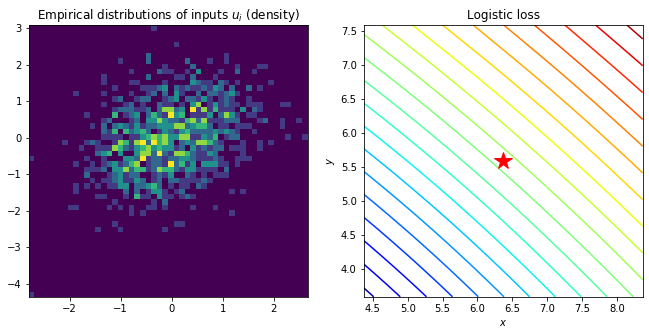

In [34]:
from LargeScaleKalmanLibrary.Evaluation import plotLogLossShape
    
print('the optimal is:\n',x_opt)
print('Diagonalized theoretical Hessian matrix=\n',np.diag(LA.linalg.eig(H)[0]))
print('Diagonalized approximated Hessian matrix=\n',np.diag(LA.linalg.eig(Happrox)[0]))

fig,(ax1,ax2)=plt.subplots(1,2,num=2,figsize=(11,5))
ax1.hist2d(U[:,0],U[:,1],50)
ax1.set_title('Empirical distributions of inputs $u_i$ (density)')
plotLogLossShape(ax2,x_opt,U,Y,nbcontours=20)
ax2.set_title('Logistic loss')
plt.show()

The true mean Hessian matrix no more match the Gaussian covariance we have used. The Hessian diagonal is weigted by the terms $\mu_i(1-\mu_i)$ which can change the condition number of the empirical covariance matrix $U^TU$.  

Let us plot now the outputs associated to each inputs with a colormap. We see clearly the linear model throught the linear separation of the Gaussian cloud.

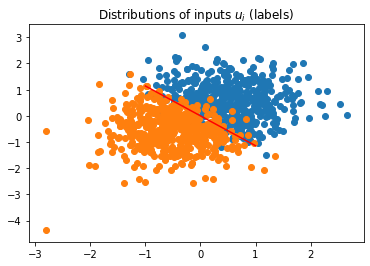

In [35]:
plt.figure(2)
x=np.arange(-1,1,0.001)
y=-x_opt[0]/x_opt[1]*x
plt.plot(x,y,'r')
plt.scatter(U[np.where((Y==0)),0],U[np.where((Y==0)),1])
plt.scatter(U[np.where((Y==1)),0],U[np.where((Y==1)),1])
plt.title('Distributions of inputs $u_i$ (labels)')
plt.show()

When the mean $\mu$ is near $1$ or the frontier $\epsilon$ is very low, $x^*$ will have a high norm and the distribution of means  will shrink to $1$ or $0$. 

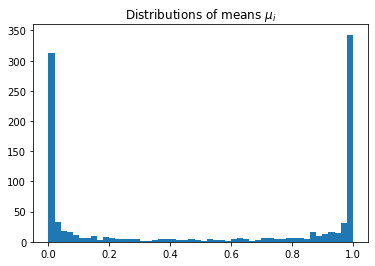

In [36]:
plt.figure(3)
plt.hist(MU,50)
plt.title('Distributions of means $\mu_i$')
plt.show()

## Second approach with 2 Gaussians

An alternative way is to consider two Gaussian of same covariance matrix but different means. If the Gaussian have the same covariance matrix, the probability $P(Y/U)$ is a sigmoid function, indeed:
\begin{align}
P(Y=1/U)&=\frac{P(U/Y=1)P(Y=1)}{P(U/Y=1)P(Y=1)+P(U/Y=0)P(Y=0)}\\
&=\frac{\mathcal{N}(\mu_1,\Sigma)\pi}{\mathcal{N}(\mu_1,\Sigma)\pi+\mathcal{N}(\mu_0,\Sigma)(1-\pi)}\\
&=\frac{1}{1+\frac{1-\pi}{\pi}\frac{\mathcal{N}(\mu_1,\Sigma)}{\mathcal{N}(\mu_0,\Sigma)}}\\
&=\frac{1}{1+\exp(-\beta^Tx-\gamma)}\\
&\\
\end{align}
with 
\begin{align}
&\beta=\Sigma^{-1}(\mu_1-\mu_0)\\
&\text{and }\\
&\gamma=\frac{1}{2}\mu_0^T\Sigma^{-1}\mu_0-\frac{1}{2}\mu_1^T\Sigma^{-1}\mu_1+\log\frac{\pi}{1-\pi}\\
&\\
\end{align}
We will suppose well balance datas ie $\pi=0.5$ and that $\mu_0=-\mu_1$. In this case $\gamma=0$ and we have not to manage a bias term.

In [182]:
def BiModal_data_generator(N,d,c,shift,seed=np.random.randint(0,1e4),covarianceInputs='ill-conditionned'):
    
    """
    Generate training datas for the logistic loss (BiModal)

    Parameters
    ----------
    N : int
        the number of training datas. 
    d : int
        the dimension of the hidden state.
    c : float
        a constant which drive the conditional number of H : mu=(1/d)^c.
    mean0 : mean of first Gaussian (y=0)
    mean1 : mean of second Gaussian (y=1)
    seed : float
        the seed used to reproduce results
    covarianceInputs : string : 
        allowed values are: 'isotropic','aligned-ill-conditionned','ill-conditionned','spikes'
    Returns
    -------
    Y : vector Nx1 
        the vector of outputs.
    U : matrix Nxd
        the training inputs organized as rows of a matrix.
    """
    
    # compute the covariance of Gaussians
    if covarianceInputs=='ill-conditionned' or covarianceInputs=='aligned-ill-conditionned':
        vec=1/np.arange(1,d+1)**c
        vec=vec/LA.norm(vec)
        Cov_u=np.diag(vec)
    if d>1 and covarianceInputs=='ill-conditionned':
        np.random.seed(seed)
        Q = special_ortho_group.rvs(dim=d)
        Cov_u=np.transpose(Q).dot(Cov_u).dot(Q)
    if covarianceInputs=='isotropic':
        Cov_u=np.identity(d)/math.sqrt(d)
    
    # we normalize the means
    np.random.seed(seed)
    mean_dir=np.random.rand(d,)
    mean_dir=mean_dir/LA.norm(mean_dir)
    mean0=np.zeros(d,)
    mean1=np.zeros(d,)
    mean0 = mean_dir*shift/2
    mean1 = -mean_dir*shift/2 
    invCov=LA.inv(Cov_u)
    
    #generate the samples
    np.random.seed(seed)
    U0=np.random.multivariate_normal(mean0,Cov_u,int(N/2)) 
    np.random.seed(seed+1)
    U1=np.random.multivariate_normal(mean1,Cov_u,int(N/2)) 
    U=np.concatenate((U0,U1))
    
    
    Y0=np.ones((int(N/2),1))*0
    Y1=np.ones((int(N/2),1))*1
    Y=np.concatenate((Y0,Y1))
    DataSet=list(zip(Y,U))
    np.random.shuffle(DataSet)
    Y,U = zip(*DataSet)
    
    #gamma=0.5*mean0.T.dot(invCov).dot(mean0)-0.5*mean1.T.dot(invCov).dot(mean1)
    #print('gamma=(must be 0)',gamma)
    opt=invCov.dot(mean1-mean0)
    #print(LA.norm(mean1-mean0))
    
    return np.array(Y),np.array(U),opt

[-9.48053482e-01 -1.63757820e+00 -2.60018518e-04 -6.87319721e-01
 -3.33633314e-01 -2.09921600e-01 -4.23442024e-01 -7.85594157e-01
 -9.02007043e-01 -1.22494035e+00 -9.52992443e-01 -1.55777087e+00
 -4.64799615e-01 -1.99630303e+00 -6.22626691e-02 -1.52423385e+00
 -9.48696391e-01 -1.27011964e+00 -3.19154204e-01 -4.50361862e-01]
The loss for the optimal is  1484951.8278515707
The percent of well classified datas is 500.0


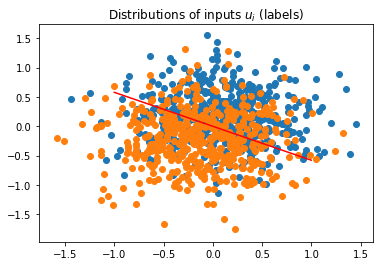

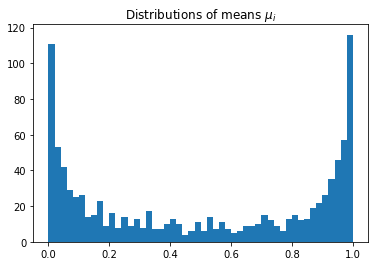

In [196]:
N=1000
d=20
c=1
shift=1
Y,U,x_opt=BiModal_data_generator(N,d,c,shift,seed=1,covarianceInputs='isotropic')
print(x_opt)

loss=LogLoss(Y,U,x_opt)
score=LogScore(Y,U,x_opt)
print('The loss for the optimal is ',loss)
print('The percent of well classified datas is',score)

#datas
plt.figure()
x=np.arange(-1,1,0.001)
y=-x_opt[0]/x_opt[1]*x
plt.plot(x,y,'r')
plt.scatter(U[np.where((Y==0)),0],U[np.where((Y==0)),1])
plt.scatter(U[np.where((Y==1)),0],U[np.where((Y==1)),1])
plt.title('Distributions of inputs $u_i$ (labels)')
plt.show()

#distribution of means
plt.figure()
MU=sigmoid(U.dot(x_opt))
plt.hist(MU,50)
plt.title('Distributions of means $\mu_i$')
plt.show()

# Normalization

## Local normalization:  recenter , rescale or not ? 

For Gaussian inputs, local normalization consist to recenter and rescale the coordinates of the input such that:
$\tilde{u}=\frac{u-\bar{u}}{\sigma_u}$. Recentering the inputs is very important and known to help convergence of stochastics algorithms providing stochastic gradient centered to $0$ [1]. The rescaling process is more questionable  for two reasons:

- It do not garentee that the eigens values of the covariance matrix of inputs are well scaled when this covariance is not aligned with the coordinate axes (see figure below).
- Rescaling preserve correlation between variables but can artificially change the entropy (and relative entropy) of datas. Indeed the entropy is not invariant to rescaling : $H(\frac{u}{\sigma_u})=H(u)-log|\sigma_u|>H(u)$ if $\sigma_u>1$. For example a sample which got a "spike" coordinate $u^i$ of very low variance $0.001$ increase his entropy of $3$ digits after rescaling. It is not a good point since when the entropy increase, that mean some information (in Fisher sense) is lost. Recentering is not concerned since the entropy is invariant to translation: $H(u-\bar{u})=H(u)$. Also, scaling by the norm of the input vector (see global normalization) is not an issue since the relative entropy of coordinates is preserved.

Second order methods as the Newton method or the Kalman filter can adapt automatically the step to the local curvature (if the estimation of the curvature is not too wrong !) and preserve all the information carried by the coordinates.

[1]: Efficient BackProp, Le Cun & al 98

Let us illustrate how the rescaling modify the Hessian matrix for the LMS loss.

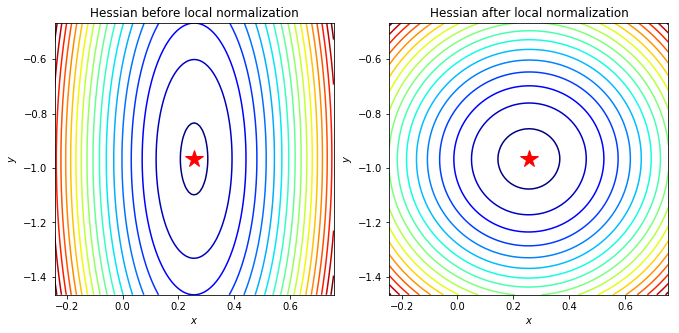

In [19]:
def normalize(U):
    meanU=np.mean(U,axis=0)
    Un=U-meanU
    stdU=np.std(U,axis=0)
    Un=Un/stdU
    return Un,meanU,stdU 

N=1000
d=2
c=3
Y,U,x_opt,Cov_u=LMS_data_generator(N,d,c,1,1,covarianceInputs='aligned-ill-conditionned')

fig,(ax1,ax2)=plt.subplots(1,2,num=2,figsize=(11,5))
plotLMSShape(ax1,x_opt,U.T.dot(U)/N,nbcontours=20)
ax1.set_title('Hessian before local normalization')
Un,meanU,stdU = normalize(U)
plotLMSShape(ax2,x_opt,Un.T.dot(Un)/N,nbcontours=20)
ax2.set_title('Hessian after local normalization')
plt.show()

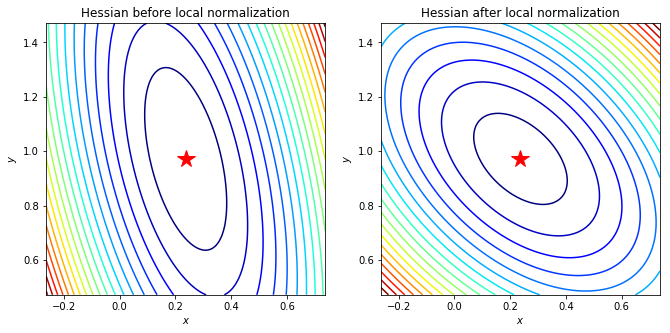

In [25]:
N=1000
d=2
c=3
Y,U,x_opt,Cov_u=LMS_data_generator(N,d,c,1,1,covarianceInputs='ill-conditionned',seed=3)

fig,(ax1,ax2)=plt.subplots(1,2,num=2,figsize=(11,5))
plotLMSShape(ax1,x_opt,U.T.dot(U)/N,nbcontours=20)
ax1.set_title('Hessian before local normalization')
Un,meanU,stdU = normalize(U)
plotLMSShape(ax2,x_opt,Un.T.dot(Un)/N,nbcontours=20)
ax2.set_title('Hessian after local normalization')
plt.show()

The Hessian is not isotropic after rescaling due to mis-alignement of axes.

## Global normalization: invariance of step-size to the norm of input

The scaling of inputs can have a strong influence on gradient descent methods. If we consider the gradient for the least mean square problem : $\nabla l(x) \sim Q x-v$ where $Q=Cov(u)$, we see that high variances of inputs can make the norm of the gradient explose. If we suppose the hessian is well aligned, the local normalization assure this variance are inferior to $1$ but in high dimension it is not sufiscent because this process do not constrain $||u||<1$. Indeed, since the norm of the input data increase with the dimension and that $||\nabla l(x)|| \sim ||u||^2$, the norm of the gradient can again explose. Suppose the data follow a multinormal distribution of isotropic variance $1$: $U \sim \mathcal{N}(0,\mathbb{I}_d)$. The norm of $U$ follow: $||U||\sim \sqrt{d}$. In other words, in high dimension, the ball of radius $1$ tends to have a radius neglible compare to the diagional of the hypercube of length $1$.

Let us experiment that:

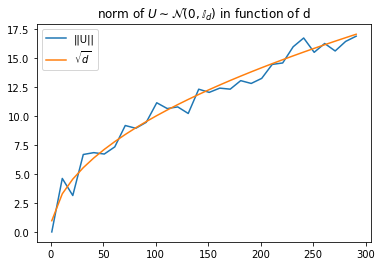

In [26]:
dmax=300
normU=np.zeros([int(dmax/10),1])
idx=0
t=range(1,dmax,10)
for d in t:
    U=np.random.multivariate_normal(np.zeros(d),np.identity(d))
    normU[idx]=LA.norm(U)
    idx=idx+1
fig=plt.figure(1)
plt.plot(t,normU,label='||U||')
plt.plot(t,np.sqrt(t),label=r'$\sqrt{d}$')
plt.legend()
plt.title('norm of $U \sim \mathcal{N}(0,\mathbb{I}_d)$ in function of d')
plt.show()

Then it is important to normalize vector inputs. We can express the optimal estimator $x^*$ before normalization in function of the optimal estimator $\tilde{x}^*$ after normalization as follow :

\begin{align}
&\frac{y}{||y||}=\frac{u^T}{||u||}\tilde{x}^*\\
&y=u^T(\tilde{x}^*\frac{||y||}{||u||})=u^Tx^*.\\
&
\end{align}

Moreover, we have $||y|| \leq ||x^*||.||u||=||\tilde{x}^*||.||y||$ such that $||\tilde{x}^*|| \geq 1$. 

If we consider now the least mean square problem :

\begin{align*}
& \underset{x}{Min} \sum_{i=1}^t (u_i^Tx-y_i)^2=\underset{x}{Min}  ||Ux-Y||^2. \\
&
\end{align*}

In the case where $N<d$, their is an infinity of solutions but we know that the solution given by the pseudo inverse $x^*=U^T(UU^T)^{-1}Y$ is the solution of minimal norm. Then if $u_i$ and $y_i$ are normalized, the solution $\tilde{x}^*$ given by pseudo inverse satisfy $\underset{||x^*|| \geq 1}{Min}||x^*||$. Since we can always find an admissible solution of norm $1$ we have $||\tilde{x}^*||=1$. In the case where $N>d$ with some additive noise, we can hope the solution will have a norm near $1$ after normalization. Then normalization give us strong prior information on the norm of the solution. And this information is more and more usefull as the dimension increase. Indeed the ball of norm $1$ get a volume which shrink to $0$ when the dimension $d$ tends to infinite. Then, in high dimension saying the solution is included in this ball will reduce the covariance of our prior on the initial guess $x_0$ (classically set to the origin $x_0=0$). For our Kalman filter, we will use a prior such that the covariance matrix on the initial guess $x_0$ is : $P_0=\mathbb{I}_d\frac{1}{||U||^2}$.